In [1]:
from numpy import *
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn
import matplotlib.patches as mpatches


#Plotly
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.grid_objs import Column, Grid

import sys
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [2]:
#Hubway 2011-2012 ride data: http://hubwaydatachallenge.org/trip-history-data/
trip_data = pd.read_csv('/Users/efandel/Desktop/hubway_2011_07_through_2013_11/hubway_trips.csv')
station_data = pd.read_csv('/Users/efandel/Desktop/hubway_2011_07_through_2013_11/hubway_stations.csv')
#trip_data.dropna(inplace=True)

In [3]:
trip_data.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


### Let's run some T-tests to see if there are significant differences in riding behavior between men & women

#### First test: Does one gender take significantly longer bike trips than the other?

In [29]:
#Create arrays for the male & female trip durations (in minutes). Exclude outliers by only using trips less than 5000 seconds (83 min) 
trip_data['duration_min'] = (trip_data.duration/60).round()
male_trip_duration_counts = trip_data[(trip_data.gender == 'Male') & (trip_data.duration<5000)].groupby(['duration_min'])['seq_id'].count()
female_trip_duration_counts = trip_data[(trip_data.gender == 'Female') & (trip_data.duration<5000)].groupby(['duration_min'])['seq_id'].count()

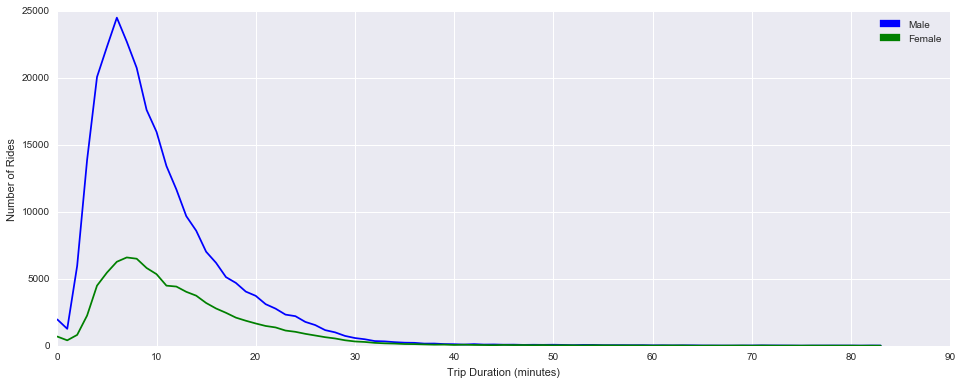

In [30]:
plt.figure(figsize=(16,6))

blue_patch = mpatches.Patch(color='blue', label='Male')
green_patch = mpatches.Patch(color='green', label='Female')

plt.plot(male_trip_duration_counts.index,male_trip_duration_counts,'-b',female_trip_duration_counts.index,female_trip_duration_counts,'-g')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Rides')
plt.legend(handles=[blue_patch,green_patch])
plt.show()

#### ^ Many more male riders in the dataset

In [45]:
trip_data.groupby(['gender'])['duration_min'].mean()

gender
Female    15.122907
Male      12.828657
Name: duration_min, dtype: float64

In [43]:
male_trip_durations = trip_data[(trip_data.gender == 'Male') & (trip_data.duration<5000)].duration_min
female_trip_durations = trip_data[(trip_data.gender == 'Female') & (trip_data.duration<5000)].duration_min

stats.ttest_ind(male_trip_durations,female_trip_durations,equal_var=False)

Ttest_indResult(statistic=-62.989843915635099, pvalue=0.0)

In [46]:
len(female_trip_durations)

86506

#### ^ T test yields p value close to 0, therefore we conclude that the average trip durations of males & females are different (females ride longer)

#### Second test: Do the age groups of male and female riders differ significantly?

In [37]:
trip_data['age'] = 2017 - trip_data.birth_date
male_age_counts = trip_data[(trip_data.gender == 'Male')].groupby(['age'])['seq_id'].count()
female_age_counts = trip_data[(trip_data.gender == 'Female')].groupby(['age'])['seq_id'].count()

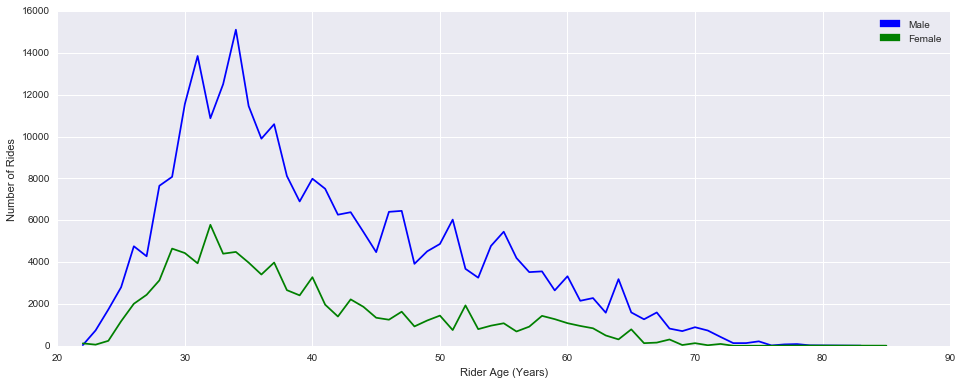

In [38]:
plt.figure(figsize=(16,6))

blue_patch = mpatches.Patch(color='blue', label='Male')
green_patch = mpatches.Patch(color='green', label='Female')

plt.plot(male_age_counts.index,male_age_counts,'-b',female_age_counts.index,female_age_counts,'-g')
plt.xlabel('Rider Age (Years)')
plt.ylabel('Number of Rides')
plt.legend(handles=[blue_patch,green_patch])
plt.show()

In [39]:
trip_data.groupby(['gender'])['age'].mean()

gender
Female    39.303295
Male      41.167259
Name: age, dtype: float64

In [47]:
male_ages = trip_data[(trip_data.gender == 'Male')].age
female_ages = trip_data[(trip_data.gender == 'Female')].age

stats.ttest_ind(male_ages,female_ages,equal_var=False)

Ttest_indResult(statistic=44.679028460020163, pvalue=0.0)

#### P value indicates there is a difference in age distribution between male and female riders (older males)

### Let's see if any trip variables are correlated

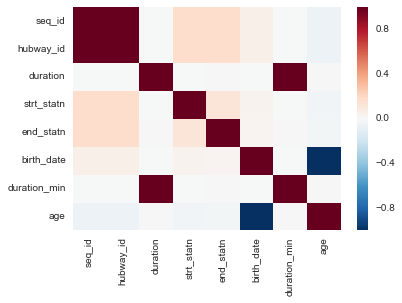

In [55]:
seaborn.heatmap(trip_data.corr())

#### Duration/duration_min and birth_date/age are obviously correlated. Other than that there isn't much correlation. Makes sense considering the variables.

### Stats over time

In [3]:
trip_data['date'] = pd.to_datetime(trip_data.start_date)

In [6]:
ts = pd.DataFrame(trip_data.duration.values,index=trip_data.date)

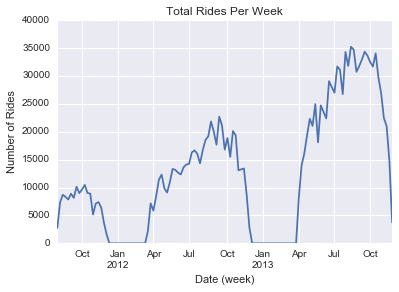

In [27]:
ts.resample('W').count().plot(legend=False)
plt.ylabel('Number of Rides')
plt.xlabel('Date (week)')
plt.title('Total Rides Per Week')

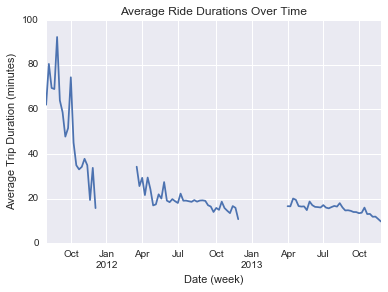

In [28]:
(ts.resample('W').mean()/60).plot(legend=False)
plt.ylabel('Average Trip Duration (minutes)')
plt.xlabel('Date (week)')
plt.title('Average Ride Durations Over Time')

### ^ As Hubway has grown in popularity (more stations added), the average trip duration has decreased significantly.